In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn.functional as F

In [3]:
words = open('names.txt').read().splitlines()
len(words), words[:8]

(32033,
 ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'])

In [4]:
# let's only have one special token, and let's have it at index 0, offset others by 1
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
num_classes = len(stoi)

In [5]:
# As we saw before that the network was underfitting
# let's increase the size of the network so it can be better
# bump hidden layers from 100 -> 300

In [6]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((3*2, 300), generator=g)
b1 = torch.randn(300, generator=g)
W2 = torch.randn((300, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]


sum(p.nelement() for p in parameters) # total number of parameters

10281

In [7]:
def build_dataset(words):
    block_size = 3 # How many characters do we take to predict the next one : 3 chars to predict the 4th
    X, Y, = [], [] # X, input | Y, labels

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append moving window

    X = torch.tensor(X)
    Y = torch.tensor(Y)    
    return X, Y

In [8]:
# Splits
import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xva, Yva = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

Xtr.shape, Ytr.shape, Xva.shape, Yva.shape, Xte.shape, Yte.shape

(torch.Size([182625, 3]),
 torch.Size([182625]),
 torch.Size([22655, 3]),
 torch.Size([22655]),
 torch.Size([22866, 3]),
 torch.Size([22866]))

In [9]:
# parameters learnable
for p in parameters:
    p.requires_grad = True

In [10]:
lr = 0.1
steps = 100000

In [11]:
lri = []
lossi = []
stepsi = []

for i in range(steps):
    # minibatches
    bs = 32
    ix = torch.randint(0, Xtr.shape[0], (bs,))
    
    # forward pass
    emb = C[Xtr[ix]] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix]) # also Ys have to be at the same index
    if (i+1)%(steps/10) == 0:
        print(f"Iteration {i}: Minibatch loss : {loss.item()}")

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepsi.append(i)
    lossi.append(loss.item())

Iteration 9999: Minibatch loss : 2.366222381591797
Iteration 19999: Minibatch loss : 2.5406689643859863
Iteration 29999: Minibatch loss : 2.5136077404022217
Iteration 39999: Minibatch loss : 2.5788767337799072
Iteration 49999: Minibatch loss : 2.422708034515381
Iteration 59999: Minibatch loss : 2.7535252571105957
Iteration 69999: Minibatch loss : 2.1850192546844482
Iteration 79999: Minibatch loss : 2.5128064155578613
Iteration 89999: Minibatch loss : 2.4804515838623047
Iteration 99999: Minibatch loss : 2.064487934112549


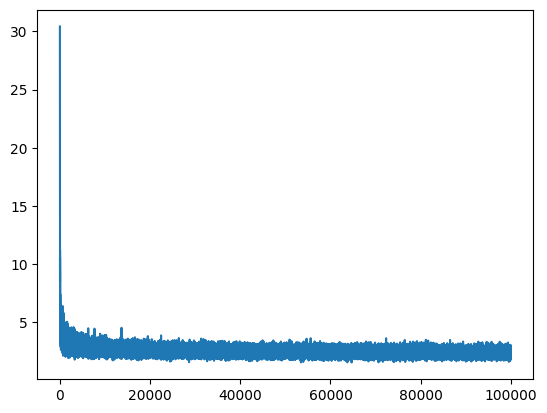

In [12]:
plt.plot(stepsi, lossi)

In [13]:
# We're expecting this to go down in a curve and then stabilize, this looks noisy
# Let's continue training
# One possibility is that the batch size is so low that we might have a noisy training

In [14]:
lr = 0.01
steps = 30000

In [15]:
lri = []
lossi = []
stepsi = []

for i in range(steps):
    # minibatches
    bs = 32
    ix = torch.randint(0, Xtr.shape[0], (bs,))
    
    # forward pass
    emb = C[Xtr[ix]] # [32, 3, 2]
    h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1) # [32, 100]
    logits = h @ W2 + b2 # [32, 27]
    loss = F.cross_entropy(logits, Ytr[ix]) # also Ys have to be at the same index
    if (i+1)%(steps/10) == 0:
        print(f"Iteration {i}: Minibatch loss : {loss.item()}")

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        p.data += -lr * p.grad
    
    # track stats
    stepsi.append(i)
    lossi.append(loss.item())

Iteration 2999: Minibatch loss : 2.6978566646575928
Iteration 5999: Minibatch loss : 2.3458621501922607
Iteration 8999: Minibatch loss : 2.247467041015625
Iteration 11999: Minibatch loss : 2.3558084964752197
Iteration 14999: Minibatch loss : 2.313822031021118
Iteration 17999: Minibatch loss : 2.2057647705078125
Iteration 20999: Minibatch loss : 2.345276355743408
Iteration 23999: Minibatch loss : 2.2940170764923096
Iteration 26999: Minibatch loss : 2.171877384185791
Iteration 29999: Minibatch loss : 2.393545389175415


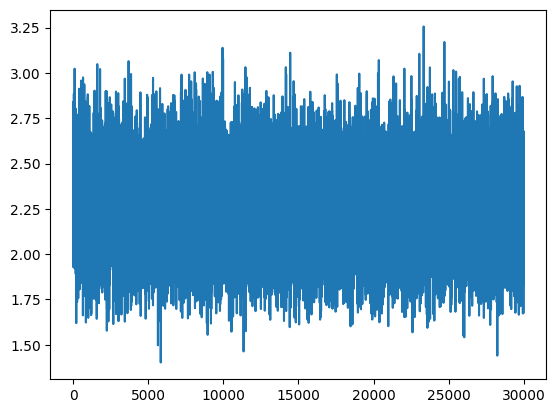

In [16]:
plt.plot(stepsi, lossi)

In [17]:
# It's hard to see anything useful above, let's check the loss

In [18]:
# Lets now get Training loss
emb = C[Xtr]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2358, grad_fn=<NllLossBackward0>)

In [19]:
# Lets now get Validation loss
emb = C[Xva]
h = torch.tanh(emb.view(-1, W1.shape[0]) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yva)
loss

tensor(2.2469, grad_fn=<NllLossBackward0>)

In [20]:
# Still underfitting as we can see
# We are expecting to see a lower loss than before
# We have a much much bigger model so we def. want the loss to be lower
# 2.27 in the previous notebook, but it also had lot more iterations

In [21]:
# THIS IS NOT GOING VERY WELL

In [22]:
# It can be
# batch size is too small
# the bottleneck of the embedding is actually the small embedding layers
# we can trying to cram too much there

In [23]:
# Let's do some neat visualization of the character embeddings to inspect for issues

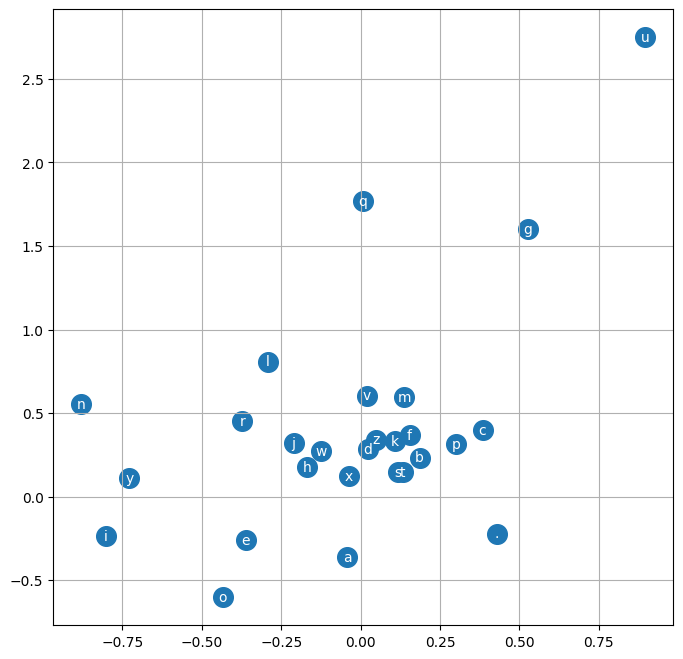

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [25]:
# Interesting to see how the training process has clustered certain characters together

In [26]:
# Another thing is that we increased the NN capacity but didn't sufficiently decrease the loss
# So, we assume that the embedding size is the bottleneck
# IN the next notebook we'll increase this embedding size and see how well we perform